In [1]:
%matplotlib inline
import sys
import json
import random
import pickle
import datetime
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from collections import Counter
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk.tokenize import MWETokenizer

def flushPrint(www):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % www)
    sys.stdout.flush()
    
#data source: https://correlatesofwar.org/data-sets/national-material-capabilities/

### Data Cleaning

Load the data and inspect

In [2]:
data = pd.read_csv('NMC-60-abridged.csv')
data.tail()

,stateabb,ccode,year,milex,milper,irst,pec,tpop,upop,cinc,version
15946,WSM,990,2012,0,0,0,36,189.0,0.0,0.000005,2021
15947,WSM,990,2013,0,0,0,36,191.0,0.0,0.000005,2021
15948,WSM,990,2014,-9,0,0,37,192.0,0.0,0.000006,2021
15949,WSM,990,2015,0,0,0,38,194.0,0.0,0.000005,2021
15950,WSM,990,2016,0,0,0,40,195.0,0.0,0.000005,2021


In [3]:
data.shape

(15951, 11)

Select the range of year and columns needed

In [4]:
data = data[['stateabb', 'year', 'cinc', 'ccode']]

In [5]:
data = data[data['year'] >= 1990]

In [23]:
df = data[data['year'] == 2007]
df.sort_values('cinc', ascending=False).head(8)

,stateabb,year,cinc,ccode
13764,CHN,2007,18.578517,710
191,USA,2007,14.972392,2
14305,IND,2007,7.705324,750
8134,RUS,2007,4.106925,365
14235,JPN,2007,3.996167,740
3040,BRA,2007,2.472574,140
14084,ROK,2007,2.306083,732
5755,GMY,2007,2.160828,255


In [7]:
codes = [710, 2, 750, 365, 740, 732, 140, 255]

In [8]:
data = data[data['ccode'].isin(codes)]

Convert CINC to percentage values

In [9]:
data['cinc'] = data['cinc'] * 100

In [10]:
data.head(10)

,stateabb,year,cinc,ccode
174,USA,1990,14.125326,2
175,USA,1991,13.713777,2
176,USA,1992,14.824486,2
177,USA,1993,15.345162,2
178,USA,1994,14.568017,2
179,USA,1995,14.037095,2
180,USA,1996,13.841243,2
181,USA,1997,13.955292,2
182,USA,1998,14.151686,2
183,USA,1999,14.250799,2


Convert the data frame into a dictionary to be plotted

In [11]:
result = data.groupby('stateabb').apply(lambda x: x.sort_values('year')['cinc'].tolist()).to_dict()

In [12]:
result.keys()

dict_keys(['BRA', 'CHN', 'GMY', 'IND', 'JPN', 'ROK', 'RUS', 'USA'])

Order the countries in the dictionary from low CINC to high CINC for better graph formatting

In [13]:
cinc_order = ['GMY', 'BRA', 'ROK', 'JPN', 'RUS', 'IND', 'USA', 'CHN']

result = {key: result[key] for key in cinc_order}

print(result)

{'GMY': [2.9267116, 3.1236051000000002, 3.1539530000000005, 3.1412087, 3.0594533, 3.11909, 3.0039914000000003, 2.9110087, 2.9356653, 2.7760297, 2.6201505, 2.6277268, 2.5257370000000003, 2.4657244, 2.3875449, 2.3106351000000003, 2.2385990000000002, 2.1608283999999998, 2.0993518, 1.9252539, 1.9416943, 1.8717172, 1.7821850000000001, 1.7428881999999999, 1.6987702, 1.6500173, 1.6592626999999998], 'BRA': [2.3121554, 2.3938439999999996, 2.4980864, 2.5086535, 2.5149306, 2.5050078, 2.5665844, 2.6329955, 2.6459632, 2.5754342, 2.5058106, 2.4349533, 2.5254341, 2.4780996, 2.471485, 2.4707537000000004, 2.4340357999999997, 2.4725745, 2.5693065, 2.4382021, 2.5338296, 2.5337497, 2.5006916, 2.4802815, 2.4388229, 2.3635525, 2.3257591], 'ROK': [1.7858532999999999, 2.0596555999999997, 2.1958981, 2.3076082, 2.3170836, 2.3970857000000003, 2.422609, 2.463026, 2.3065768, 2.3389154999999997, 2.3389466000000003, 2.3278184, 2.4154447, 2.3511325999999997, 2.316352, 2.3448244, 2.3186637, 2.306083, 2.2562871, 2.2003

Extract Years as an array

In [14]:
years=np.array(sorted(data['year'].unique()))
years

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016], dtype=int64)

### Plotting the graph

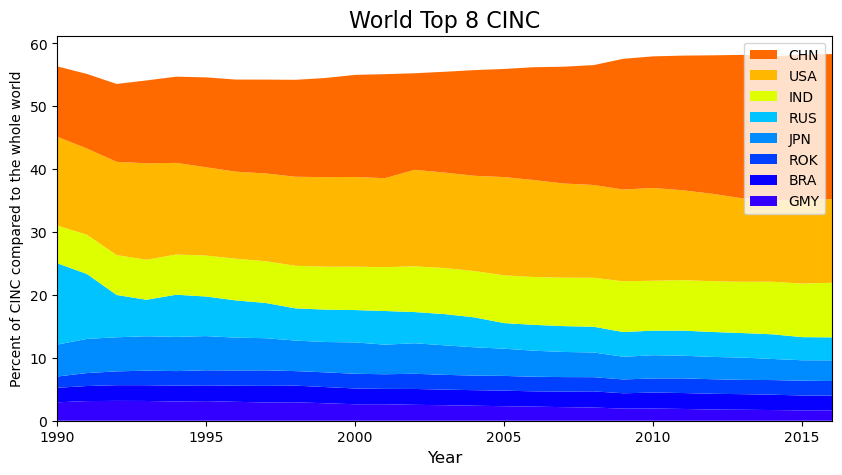

In [24]:
COLORS = ["#3300ff", "#0800ff", "#0040ff", "#008cff", "#00c3ff","#ddff00", "#ffb700", "#ff6a00"]
height=5
fig, ax = plt.subplots(figsize=(height*2, height))
ax.stackplot(years, result.values(),colors=COLORS,labels = result.keys(),baseline = "zero")
ax.legend(loc='upper right', reverse=True)
ax.set_title('World Top 8 CINC', size = 16)
ax.set_xlabel('Year', size = 12)
ax.set_ylabel('Percent of CINC compared to the whole world')
plt.xlim(1990,2016);